# Numpy Basics

[Presented at [Neurohackademy 2020](https://neurohackademy.org) by [Tal Yarkoni](https://talyarkoni.org)]
[Lightly edited for [Neurohackademy 2021](https://neurohackademy.org) by [Noah C. Benson](https://nben.net/)]

In this tutorial, we'll introduce numpy—Python's workhorse numerical computing library. We'll begin by motivating the need for a package like numpy, especially in domains with large datasets, like neuroimaging. Then we'll walk through some numpy basics. We'll introduce the core N-Dimensional Array structure; explore ways to initialize, inspect, and index arrays; and review some basic ways to manipulate them, including restructuring operations and application of basic mathematical and statistical functions. At the end of this tutorial, you should have a general sense of what numpy arrays are good for and how they work, though you'll probably need to put in some time working with them to really get a good feel for them.

## From naive loops to n-dimensional arrays
In many disciplines, data analysis consists largely of the analysis of *tabular* data—meaning, two-dimensional tables where data are structured into rows and columns, with each observation typically taking up a row, and each column representing a single variable. Neuroimaging data analysis also often involves tabular data, and we'll spend a lot of time later on discussing some of the tools Python provides for working efficiently with tabular data. However, one of the notable features of neuroimaging is that datasets are often large, and naturally tend to have many dimensions.

For example, consider a typical "resting state" fMRI study, in which participants simply lie in the scanner at rest while the machine around them does its thing. Suppose we have 20 participants, each scanned for roughly 30 minutes, with a repetition time (TR)—i.e., the duration of acquisition of each fMRI volume—of 1 second. If the data are acquired at an isotropic spatial resolution of 2mm (i.e., each brain "voxel", or 3-dimensional pixel is 2 mm along each dimension), then the resulting dataset might have approximately 20 x 1800 x 100 x 100 x 100 = 36 billion observations. That's a lot of data! Moreover, each subject's data has a clear 4 dimensional structure—the 3 spatial dimensions, plus time. If we wanted to, we could also potentially represent subjects as the 5th dimension, though that involves some complications, since at least initially, different subjects' brains won't be aligned with one another—we'd need to spatially register them for that.

It may be helpful to visualize a single subject's data to get a better sense of what the data look like. Of course, most of us mere mortals don't naturally think in 4 dimensions, so we'll need to cheat a little bit. We'll take advantage of the fact that the 3 spatial dimensions have an obvious structure to them, and then we'll concatenate consecutive 3d volumes along a time axis to get the 4th dimension. Here's the idea (image from the [nilearn docs](https://nilearn.github.io/building_blocks/manual_pipeline.html)):

<br />

![](images/niimgs.jpg)

<br />

We will typically want to access this data in pretty specific ways. That is, rather than applying an operation to every single voxel in the brain, at every single point in time, we usually want to pull out specific *slices* of the data, and only apply an operation to those slices. Say for example we're interested in a voxel in the amygdala. How would we access only that voxel, at every time point?

A very naive approach that we could implement in pure Python would be to store all our data as a nested series of Python lists: each element in the first list would be a list containing data for one time point; each element within the list for each time point would itself be a list containing the 2d slices at each x-coordinate; and so on. Then we could write a series of 4 nested for-loops to sequentially access every data point (or voxel) in our array. For each voxel we inspect, we could then determine whether the voxel is one we want to work with, and if so, apply some operation to it.

Basically, we'd have something like this (note that this is just pseudocode, not valid Python code, and you can't execute this snippet!):

```python
for t in time:
    for x in t:
        for y in x:
            for z in y:
                if z is in amygdala:
                    apply_my_function(z)
```

Something like the above would probably work just fine. But it would be very inefficient, and might take a while to execute. Notice that even if we only want to access a single amygdala voxel at each timepoint (i.e., 1800 data points in total, if we stick with our resting state example from above), our naive looping approach still requires us to inspect every single one of the 1.8 billion voxels in our dataset—even if all we're doing for the vast majority of voxels is deciding that we don't actually need to use that voxel in our analysis! This is, to put it mildly, A Bad Thing.

Computer scientists have developed a notation for more precisely describing how much of a bad thing it is: *Big O notation*, which gives us a formal way of representing the time complexity of an algorithm. In Big O notation, the code above runs in $O(n^4)$ time. Meaning, for any given dimension size $n$ (we assume for simplicity that $n$ is the same for all dimensions), we need to perform on the order of $n^4$ computations. To put this in perspective, just going from $n = 2$ to $n = 4$ means that we go from $2^4 = 16$ to $4^4 = 256$ operations. You can see how this might start to become problematic as $n$ gets large.

The lesson we should take away from this is that writing naive Python loops just to access the values at a specific index in our dataset is a bad idea.

### List indexing
Fortunately, since we've already covered list indexing in Python, we have a better way to access the amygdala data we want. We know that the outer dimension in our nested list represents time, and we also know that the spatial index of the amygdala voxel we want will be constant across time points. This means that instead of writing a 4-level nested for-loop, we can do the job in just a single loop. If we know that the index of the amygdala voxel we want in our 3-d image is [20, 18, 32], then the following code suffices (again note that this code can't be executed):

```python
amygdala_values = []

for t in dataset:
    amygdala_values.append(t[20][18][32])
```

That's a big improvement! In terms of time complexity! We've gone from an $O(n^4)$ to an $O(n)$ algorithm. The time our new algorithm takes to run is now linear in the number of timepoints in our dataset, rather than growing as a polynomial function of it.

### Towards a specialized array structure
Unfortunately, our new approach still isn't great. One problem is that performance still won't be so good, because base Python isn't really optimized for the kind of operation we just saw—i.e., indexing repeatedly into nested lists. For one thing, Python is a dynamically typed language, so there will be some overhead involved in accessing each individual element (because the interpreter has to examine the object and determine its type), and this can quickly add up if we have millions or billions of elements.

The other big limitation is that, even if lists themselves were super fast to work with, the Python standard library provides limited functionality for doing numerical analysis on them. There are a lot of basic numerical operations we might want to apply to our data that would be really annoying to write in core Python. For example, Python lists don't natively support matrix operations, so if we wanted to multiply one matrix (represented as a list of lists) by another, we'd probably need to write out a series of summations and multiplications ourselves inside for-loops. And that would be completely impractical given how basic and common an operation matrix multiplication is.

The bottom line is that, as soon as we start working with large, or highly structured datasets—as is true of most datasets in neuroimaging—we're going to have to look beyond what Python provides us in its standard library. Lists just aren't going to cut it; we need some other kind of data structure—one that's optimized for numerical analysis on large, N-dimensional datasets. This is where *numpy* comes into play.

## Numpy
Numpy is the backbone of the numerical and scientific computing stack in Python; many of the libraries we'll cover in this course (SciPy, pandas, scikit-learn, etc.) depend on it internally. Numpy provides many data structures optimized for efficient representation and manipulation of different kinds of high-dimensional data, as well as an enormous range of numerical tools that help us work with those structures. Because numpy is so fundamental to scientific computing in Python, we'll spend most of our time in this notebook learning how to use it. Then we'll devote a little bit of time at the end to two other important packages that build on numpy (scipy and pandas).

### Importing numpy
Recall that, in Python, the default namespace contains only a small number of built-in functions. To use any other functionality, we need to explicitly import it into our namespace. Let's do that for numpy:

In [1]:
import numpy as np

By convention, numpy is imported as `np` for brevity. This is a general convention in Python; most widely-used packages have standard abbreviations that everyone in the community uses. While Python itself won't complain if you write, say, `import numpy as my_favorite_numerical_library`, we strongly recommend sticking with the conventional abbreviations, as they make it easier for everyone else to understand what your code is doing at a glance.

### The NDArray (n-dimensional array)
The core data structure in numpy is the *n-dimensional array* (or `ndarray`). As the name suggests,  an `ndarray` is an array with an arbitrary number of dimensions. Unlike Python lists, numpy arrays are homogeneously typed—meaning, every element in the array has to have the same data type. You can have an array of floats, or an array of integers, but you can't have an array that mixes floats and integers (though numpy does have a [structured array](https://numpy.org/doc/stable/user/basics.rec.html) data type we won't cover here that provides a way of representing heterogeneous data).

### Creating NDArrays
Like any other Python object, we need to initialize an `ndarray` before we can do anything with it. Numpy provides us with several ways to create new arrays. Let's explore a couple.

#### Initializing an array from an existing list
Let's start by constructing an array from existing data. Assume we have some values already stored in a native Python iterable object (typically, a list), and we want to convert that object to an ndarray so that we can perform more efficient numerical operations on it. In this case, we can just pass the iterable object directly to `np.ndarray()`. 

In [2]:
np.array([1, 2, 3, 4, 5, 6])

array([1, 2, 3, 4, 5, 6])

Numpy is pretty good about figuring out what kind of array we want based on the input data; for example, if we pass in a list of lists, where each of the inner lists has the same number of elements, numpy will infer that we want to construct a 2-dimensional array:

In [3]:
# A Python list of lists
my_list = [[1, 2, 5], [4, 1, 7]]

# Construct an array from the list
my_arr = np.array(my_list)

my_arr

array([[1, 2, 5],
       [4, 1, 7]])

The first time you see a printed representation of a numpy array, as in the above output, it might look a little confusing. But the visual representation closely resembles what we'd see if we were to print a nested list in Python. In the 2-dimensional case above, the elements of the outer list are the values along the first dimension, and each inner list gives the values along the second dimension. This ends up giving us a nice tabular representation, where, at least for small arrays, we can just read off the values from the output. For example, the first row of the array contains the values [1, 2, 5]; the second column of the array contains the values [2, 1]; and so on.

**Exercise**: extend the above principle into 3 dimensions: create a list of list of lists, initialize an array from the list, and print into the screen. Make sure you understand how the values displayed visually map onto the dimensions of the array.

#### Initializing an empty array
Alternatively, we can construct a new array from scratch and fill it with some predetermined value--most commonly zero. We can do this easily in numpy using the conveniently-named `zeros()` function. In many practical applications, we can think of this as an "empty" array (though technically we could also create a *truly* empty array that has *no* assigned values using the `empty()` function).

The `zeros()` function takes a mandatory `shape` tuple as its first argument; this specifies the dimensions of the desired array.

In [4]:
# Create a new 10 x 10 array
arr_2d = np.zeros((5, 10))

# Create a new 3-d array with dimensions 2, 4, 8
arr_3d = np.zeros((2, 4, 8))

#### Other array initializers
Numpy has many other functions for creating new arrays. Here are a few:

In [5]:
# Returns an array of evenly-spaced values within a certain range
np.arange(4, 10)

array([4, 5, 6, 7, 8, 9])

In [6]:
# Generate normally distributed values drawn from a distribution with the specified shape.
# There are several other random number generating functions in the np.random module.
# Here we generate a 10 x 2 array of values sampled from a normal distribution with
# mean of 2 and sd of 4.
np.random.normal(2, 4, size=(10, 2))

array([[ 6.92703991,  0.91830585],
       [ 8.08672622, -4.7638229 ],
       [ 2.11189965,  9.10316441],
       [-0.80748021,  3.28684341],
       [-0.22576133,  5.11359496],
       [ 5.36586215,  6.7436626 ],
       [ 0.07226779, -0.47684895],
       [ 3.87421357,  3.30600382],
       [ 0.18306673, -5.54673859],
       [-5.81868459,  7.73114251]])

In [7]:
# np.full() is like np.zeros() and np.ones(), but fills the array with the
# specified value instead of 0 or 1.
np.full((5, 5), 400)

array([[400, 400, 400, 400, 400],
       [400, 400, 400, 400, 400],
       [400, 400, 400, 400, 400],
       [400, 400, 400, 400, 400],
       [400, 400, 400, 400, 400]])

### Inspecting NDArrays
Like most other Python objects, the `ndarray` class has all kinds of attributes we can access and inspect, if we want to understand the structure and content of the data.

#### Array shape
One indispensable method is `.shape`, which tells us the shape of the array:

In [8]:
my_list = [[1, 2, 5], [4, 1, 7]]

my_arr.shape

(2, 3)

This array has shape `(2, 3)`—i.e., there are 2 elements along the first axis and 3 along the second axis.

We can tell that the array is 2-dimensional from the number of elements in the `shape` tuple. But we could also get the number of dimensions directly using the `ndim` attribute:

In [9]:
my_arr.ndim

2

#### Array data type
As we noted above, NDArrays are homogeneous: all the values in an array have the same type. We can find out that type from the `dtype` attribute:

In [10]:
print("dtype of my_arr:", my_arr.dtype)
print("dtype of arr_3d:", arr_3d.dtype)

dtype of my_arr: int64
dtype of arr_3d: float64


When initializing an array from a list, numpy will infer a suitable datatype by inspecting the types of the elements in the input. In the above example, `my_arr` has a `dtype` of `int64`, because we initialized it by passing in a list of Python `int`s. (**Exercise**: Create a Python list containing heterogeneous types, and see what happens to the inferred `dtype` when you create a numpy array. Try different combinations of types, including a dictionary.)

By contrast, `np.zeros()` will always create an array of floats by default. If we want to explicitly control the dtype of the constructed array, we can pass a `dtype` argument:

In [11]:
np.zeros((5,), dtype=int)

array([0, 0, 0, 0, 0])

In this case, we're stipulating that the constructed array should have an integer datatype.

You may have noticed that the data types numpy uses look a little different from basic Python types. Instead of the familiar `int` and `float`, for instance, we now see `int64` and `float64`. This distinction is important, as numpy data types aren't the same as base Python types (though they have many similar behaviors). Also, numpy has many more [numerical data types]((https://numpy.org/doc/stable/reference/arrays.dtypes.html)) than base Python.

### Indexing arrays
We've seen how we can create arrays and describe them; now let's talk about how we can get data in and out of arrays. We already know how to index Python lists, and array indexing in Python will look quite similar. But numpy indexing adds considerably more flexibility and power, and developing array indexing facility is a critical step towards acquiring general proficiency with the package.

#### Indexing in one dimension
Let's start with the simplest case: indexing 1-dimensional arrays. This looks very much like list indexing.

Let's create a 1-d array to work with:

In [12]:
arr = np.array([7, 1, 9, 14, 2, 8, 9, 6, 10, 4])

arr

array([ 7,  1,  9, 14,  2,  8,  9,  6, 10,  4])

To access the $i^{th}$ element in the array, we follow the Python list syntax:

In [13]:
arr[3]

14

Observe that numpy arrays use 0-based indexing, like base Python and most other programming languages, rather than the 1-based indexing found in several other data-centric languages (e.g., R and MATLAB). So `arr[3]` returns the 4th value in the array (i.e., `14`), not the 3rd.

Numpy arrays also support two other important syntactic conventions found in Python lists: indexing from the end of the array, and "slicing" the array to extract multiple contiguous values.

To index from the end, we use the minus sign (`-`):

In [14]:
arr[-2]

10

This gives us the 2nd last value in the array.

To slice an array, we use the colon (`:`) operator, passing in the positions we want to start and end at:

In [15]:
arr[2:6]

array([ 9, 14,  2,  8])

Notice that the start index is inclusive and the end index is exclusive (i.e., in the above example, the resulting array includes the value at position `2`, but excludes the one at position `6`).

We can also omit the start or end indexes, in which case numpy will return *all* positions up to, or starting from, the provided index. For example, to get the first 4 elements:

In [16]:
arr[:4]

array([ 7,  1,  9, 14])

If we want to get even fancier, we can add a third number to the requested slice. This tells us the size of the *step* used in slicing (i.e., the syntax is `start:end:step`). For example, to get every third value in the list, starting with the 2nd element, and ending before the second-last element:

In [17]:
arr[1:-2:3]

array([1, 2, 6])

#### Indexing in multiple dimensions
Once we start working with arrays with more than one dimension, indexing gets a little more complicate—both because the syntax is a little different, and because there's a lot more we can *do* with multi-dimensional arrays.

Let's explore indexing in 3 dimensions. We could easily create a new array, just as we did earlier. But instead, we'll cheat a bit and use some real neuroimaging data—specifically, an anatomical brain volume. This will keep things a bit more interesting, and should also make it easier to build intuitions about arrays, as we'll be working with numbers that have some concrete meaning.

The reason I say we're cheating a bit is that we're not going to cover the representation or reading in of neuroimaging data just yet; that comes later on in the course, in the presentation on NiBabel. NiBabel is a Python library that supports reading, writing, and manipulation of a wide range of common neuroimaging formats. Because it'll be covered in much more detail later, I won't explain what we're doing here, except to say that in the following two lines, we're loading an anatomical brain image (in Nifti format) into Python, and then extracting the actual 3-dimensional data (conveniently already stored in a numpy array) into its own variable.

In [18]:
import nibabel as nib

img = nib.load('data/anatomical.nii.gz')
data = img.get_fdata()

Now the `data` variable is an NDArray that behaves just like the ones we've already seen. Let's interrogate it:

In [19]:
data.shape

(91, 109, 91)

In [20]:
data.dtype

dtype('float64')

As you can see, we have a 3-dimensional array with shape (91, 109, 91). This is the shape of the famous MNI152 2mm template—probably the single most common standard space in which neuroimaging data analysis has historically been conducted. That's not a coincidence; the image we just loaded *is* the MNI152 2mm anatomical image. You can find more details about it [here](http://nist.mni.mcgill.ca/?p=858).

Now we can start working with our image. To maximize clarity, let's assign the labels $i$, $j$, and $k$ to the three axes (or dimensions) of the array, where $i$ is the first dimension, $j$ is the second, and $k$ is the third. Let's retrieve a single value from the array—say, the one stored at $i$ = 45, $j$ = 54, $k$ = 45. Just as with one-dimensional indexing, we again pass the indexes inside square brackets. But this time, we separate the axes with commas:

In [21]:
data[45, 54, 45]

5391.0

The value we get tells us the intensity of the MR signal at the specified voxel. If we were to plot the volume visually (and we will, momentarily), we could interpret the values as visual parameters (e.g., brightness or hue). While the absolute numbers in the image have no meaningful interpretation here, the relative variation *across* voxels certainly does, as we'll demonstrate below.

So much for single values; what about multiple values? The slicing syntax used with Python lists and 1-dimensional numpy arrays still works fine. For example, to get the first 20 values along the $i$ axis, but only for $j$ = 54 and $k$ = 45:

In [22]:
data[:20, 54, 45]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0., 4507., 5647., 6082., 6315., 6487., 6590., 6613.,
       6539., 6312.])

The first few values in the array are 0, presumably because they're outside the brain, and hence carry no anatomical information.

Notice that even though the `data` array we started with had 3 dimensions, the sub-array we get back is a 1-dimensional numpy array. We can verify this by inspecting the shape of the result:

In [23]:
data[:20, 54, 45].shape

(20,)

The latter two dimensions are implicitly omitted, because we only requested a slice along the first dimension (try replacing the code in the above cell with `data[:20, 54:55, 45]` and see what happens). 

What about slicing along multiple dimensions simultaneously? That also works fine. Let's say we want to get the 2-dimensional plane defined by $k = 45$. If we don't have starting and ending positions in mind—i.e., we want to get *all* available values in the plane, we can pass the `:` operator in the desired axes without further elaboration:

In [24]:
data[:, :, 45]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Let's verify that we get back a 2-dimensional array:

In [25]:
data[:, :, 45].shape

(91, 109)

To help build intuitions about what's going here, let's make things more concrete. We're going to cheat again and once more borrow content from course material we haven't yet covered--in this case, from the material on visualization. As before, I won't bother explaining the code just yet; we'll talk about that later on. Let's just focus on the result.

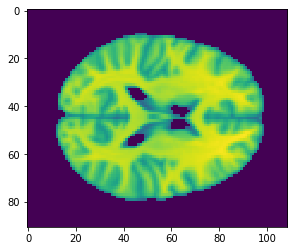

In [26]:
# same slice as above
axial_slice = data[:, :, 45]

# matplotlib is Python's workhorse plotting library
import matplotlib.pyplot as plt

# imshow plots a 2d array as an image
plt.imshow(axial_slice);

Just like that, in a single line of code, we've turned a 2-dimensional array of numbers into a plot of an axial brain slice!

Granted, it probably isn't the most beautiful brain image anyone's ever seen; gray matter, as its name implies, is usually gray (or at worst, pinkish), and not neon green. But no matter. In later parts of the course, we'll mess around with Python's vast visualization capabilities, and you'll be able to tweak the colors, and everything else about the above figure, to your heart's content. For now, the important thing is just to gaze in awe upon the image above.

It's easy to take what we just did for granted, seeing as it only took us 3 - 4 line of code. As we get deeper into the course, and do far more sophisticated things with neuroimaging data, the above example will probably start to seem really trivial (if it doesn't already). Still, it's worth taking a moment to think about what we were able to accomplish in a matter of seconds, thanks to the heroic efforts of tens of thousands of scientists, engineers, and software developers that came before us. We took a 2-dimensional array containing about 10,000 floating-point numbers, and just by mapping those values onto different colors, we were able to project the array onto a visual plot in a way that allows us to immediately *see* and make sense of an actual human brain--a brain that was imaged using an extremely large magnet, while still safely housed inside somebody's skull (technically, the image is derived from many people's brains, but you get the point). That's pretty remarkable, isn't it?

#### From image to world coordinates
If you've worked with human brain images before, you might recognize the slice plotted above: in the standard coordinate space used in MRI, it's the slice you get at $z = 0$—i.e., an axial (or transverse, or horizontal) slice through roughly the middle of the brain. In this space, the origin (i.e., the point with coordinates (0, 0, 0)) is conventionally located at the midpoint of the line between the anterior and posterior commissures (the AC-PC line).

Armed with this knowledge, you might be thinking that it should be easy to plot a brain slice along *any* of the conventional axes—axial (as above), sagittal, or coronal. And you'd be right. Now that we know that the image-space dimensions we've labeled $i$, $j$, and $k$ correspond to the world-space axes $x$, $y$, and $z$, it's a snap to plot any slice we want. For example, to plot the coronal slice at $y = 10$:

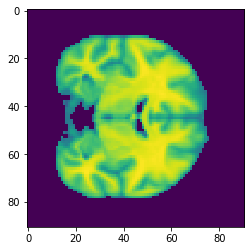

In [27]:
plt.imshow(data[:, 59, :]);

You might notice that the orientation of the image is wrong (at least, relative to the way coronal slices are usually oriented in images); we'll fix that in a moment.

You might also notice that the index we passed (`59`)—is 5 off from the center of the array (i.e., `59 - 54 = 5`), and not 10, as you might expect given that we wanted the slice at $y = 10$. But remember: image space and world space are different things. Later in the course, when we cover NiBabel, we'll talk at length about the *affine* array contained in every Nifti image file's header, which tells us exactly what the mapping between the two spaces is. For now, we can dispense with any confusion by observing that each voxel in our image is 2 mm in width, so moving 10 mm in world space (from $y = 0$ to $y = 10$) corresponds to a move of only 5 element in image space.

#### Setting values
So far we've only used the indexing syntax to *get* values from arrays. But it also allows us to *set* new values in an array. Setting a single value operates just the way it does with lists:

In [28]:
arr = np.array([7, 1, 9, 14, 2, 8, 9, 6, 10, 4])
arr[2] = 100
arr

array([  7,   1, 100,  14,   2,   8,   9,   6,  10,   4])

What about multiple values? Can we replace the values of a sub-array in a single shot? The answer is yes.

In [29]:
arr[2:4] = [1, 5]

And the same goes for arrays with more than one dimension:

In [30]:
# create a 5 x 5 array of zeros
arr_2d = np.zeros((5, 5))

# create a 3 x 3 array of ones.
# np.ones() is just like np.zeros(), but fills the matrix with ones
ones = np.ones((3, 3))

# replace a 3 x 3 sub-array of arr_2d with ones
arr_2d[:3, 2:] = ones

arr_2d

array([[0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

###  Restructuring arrays
Sometimes the existing structure or shape of an array doesn't lend itself well to the operations we intend to perform. This is common, for example, when doing linear algebra, which often needs arrays to have dimensions that align with one another in certain ways. Fortunately, numpy gives us lots of tools for restructuring arrays in various ways. Let's explore a few of them.

#### Reshaping
One very useful function is `reshape()`, which takes a single array as input and returns another array with a different shape as output (technically `reshape*()` returns a *view* on an array, but we'll cover that in the second part of this tutorial).

First, let's make a 1-d array with 100 elements:

In [31]:
x = np.arange(100)
print("x:", x)

x: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Now we'll reshape it. The `reshape()` function takes two mandatory arguments: the array we want to reshape, and the new shape we want:

In [32]:
# 1st argument is the array to be reshaped; 2nd is the target shape
np.reshape(x, (10, 10))

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

As you might intuitively expect, the new shape has to be compatible with the old one. It would be strange if we could, say, reshape an array with shape `(100,)` into one with shape `(179, 1)`; where would the extra 79 elements in the latter magically come from? (You can verify this for yourself by replacing `(10, 10)` with `(179, 1)` above, and watching numpy yell at you.)

The easiest way to ensure compatible shapes is to provide a new shape tuple that implies an equal number of elements to the existing array. Meaning, the product of the old shape tuple should be equal to the product of the new one. In the above example, we created a 1-dimensional array with 100 values, and then reshaped it to a 2-dimensional array with shape `(10, 10)`. This works, because `(100,)` and `(10, 10)` both imply the same number of elements (100). We could also have reshaped to `(50, 2)`, `(4, 25)`, and so on.

**Exercise**: starting with the same `x` array above, reshape it so that instead of having 2 dimensions, the output now has 4 dimensions (of any size).

#### Transposition
Another common restructuring operation is *transposition*, which reverses the order of an array's axes. This is easy to visualize in two dimensions:

In [33]:
x = np.ones((5, 2))
print("x:\n", x)
print("\nx transposed:\n", np.transpose(x))

x:
 [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]

x transposed:
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


The transposition reverses the axes, so that the shape `(5, 2)` becomes `(2, 5)`. This also works in additional dimensions (e.g., transposing an array with shape `(10, 5, 2)` gives one with shape `(2, 5, 10)`).

For convenience, we can also use an array's `.T` attribute as shorthand for `np.transpose()`:

In [34]:
x = np.ones((5, 2))
print(x.T)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


Remember the misoriented coronal brain slice we plotted earlier? Now that we know how to transpose an array, we're in a position to fix that!

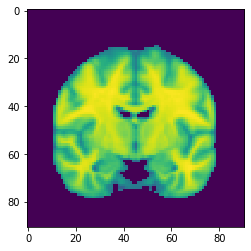

In [35]:
coronal = data[:, 59, :]

reoriented = coronal.T[::-1, :]

plt.imshow(reoriented);

Notice that we actually stacked two operations here: first we transposed the coronal slice (`coronal.T`), and then we reindexed its first axis.

**Exercise**: if you're not sure what the  `::-1` slicing syntax above is doing, see if you can figure it out by experimenting with the above code. Try leaving out the transposition and/or the re-indexing steps and seeing what happens to the image. *Bonus*: rewrite the expression so that an indexing step happens *before* the transposition step, but still produces the correct image orientation.

#### Stacking and splitting arrays
Sometimes we want to *concatenate*, or *stack*, multiple arrays into a single one. Numpy provides a `concatenate()` function that allows us to accomplish this efficiently. It takes a sequence of arrays as input, and concatenates them along the desired axis:

In [36]:
x = np.ones((10, 2))
y = np.ones((10, 2)) * 2

xy = np.concatenate([x, y], axis=0)

xy.shape

(20, 2)

Above we concatenated two axes of shape `(10, 2)` along the first axis (i.e., `axis=0`). We could also concatenate along the second axis:

In [37]:
xy = np.concatenate([x , y], axis=1)

xy.shape

(10, 4)

For convenience, numpy also provides `vstack()` and `hstack()` functions, which are just wrappers around `concatenate()` that take care of the axis argument for you (as long as you only need to concatenate along one of the first two axes). I.e., `vstack()` (for "vertical stack") is equivalent to calling `concenate()` with `axis=0`, and `hstack()` (for "horizontal stack") is equivalent to calling it with `axis=1`. (As an **exercise**, you can try replacing the `concatenate()` calls above with the stacking functions to produce the same result.)


Just as we can stack multiple arrays into one, we can also split a single array into multiple parts. Numpy provides `split()`, `vsplit()`, and `hsplit()`, which do basically the opposite of `concatenate()`, `vstack()`, and `hstack()`, respectively.

In [38]:
x = np.array([1, 2, 5, 9, 3, 1, 4, 5, 2, 9, 4])

np.split(x, [3, 7], axis=0)

[array([1, 2, 5]), array([9, 3, 1, 4]), array([5, 2, 9, 4])]

Note that `split()` takes one more argument than `concatenate()`, because we need to specify the split points along the arget axis. Above, we specify that we want to split the array at the indices `3` and `7`.

### Array arithmetic
The main purpose of the array data structure is to support numerical operations, so let's look at some of those. We'll start with simple arithmetic: addition, subtraction, etc. In numpy, all arithmetic operations are applied to arrays in an *element-wise* fashion. By element-wise, we mean that the operation is applied identically to every element in the array. For example:

In [39]:
x = np.array([1, 6, 4, 2])

y = x * 2

y

array([ 2, 12,  8,  4])

Each element in `y` is double the value at the corresponding position in `x`.

The multiplication operation should look familiar, as it uses the standard Python operator `*`. The same goes for the other operators natively available in Python: addition (`+`), subtraction (`-`), division (`/`), power (`**`), modulo (`%`), and floor (or integer) division (`//`). Some more examples:

In [40]:
# np.arange() builds an array with sequentially increasing values
x = np.arange(10)
print("x:", x)

print("\nAdd 10 to x:", x + 10)
print("Divide x by 2:", x / 2)
print("x modulo 2:", x % 2)
print("x raised to the power of 3:", x ** 3)

x: [0 1 2 3 4 5 6 7 8 9]

Add 10 to x: [10 11 12 13 14 15 16 17 18 19]
Divide x by 2: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
x modulo 2: [0 1 0 1 0 1 0 1 0 1]
x raised to the power of 3: [  0   1   8  27  64 125 216 343 512 729]


For all of these operations, so long as the two operands are an array and a single number, the output of the operation will always be a new array with the same dimensions as the input array.

What about arithmetic operations where the other operand *isn't* a number? Can we, for example, subtract one array from another? Yes! We just have to make sure to that the two arrays have the same shape:

In [41]:
a = np.array([10, 5, 2, 8])
b = np.array([2, 3, 4, 7])

a - b

array([ 8,  2, -2,  1])

The above subtraction still proceeds element-wise: the first element in `b` is subtracted from the first element in `a`; the second element in `b` is subtracted from the second in `a`; and so on.

#### In-place operations
When we perform an arithmetic operation like the ones above, numpy will create and return an entirely new array. But sometimes we want to modify an existing array, without creating any new variables. In such cases, we can append the `=` operator to the arithmetic operator to indicate that we want the result to be stored in the same array we used as input. This is known as *in-place* modification:

In [42]:
x = np.array([1, 6, 4, 2])

# Shorthand for x = x * 2
x *= 2

x

array([ 2, 12,  8,  4])

### Mathematical functions
Once we've imported numpy into our namespace, we have easy access to dozens of mathematical functions we can use to transform arrays in various ways. Many of these operate element-wise on an array. For example, we can use `np.abs()` to get the the absolute value of each element:

In [43]:
y = np.array([1, 5, 48, -7, 12, 6, -4, 1.8, 9])

# Take the absolute value of each element
np.abs(y)

array([ 1. ,  5. , 48. ,  7. , 12. ,  6. ,  4. ,  1.8,  9. ])

And similarly, `np.log()` gives us the natural log of each element:

In [44]:
y = [4, 5, 1, 100, 75]

# Natural log of each element
np.log(y)

array([1.38629436, 1.60943791, 0.        , 4.60517019, 4.31748811])

There's also support for the full complement of trigonometric functions (`sin()`, `tan()`, `cosh()`, etc.):

In [45]:
y = [30, 90, 51, 216]
np.cos(y)

array([ 0.15425145, -0.44807362,  0.7421542 , -0.71798508])

### Aggregation/summarization
Another set of functions help us summarize or aggregate arrays in various ways. These are mostly *unary* functions, meaning that they take a single array as an argument.

For example, `sum()` produces the sum of the elements:

In [46]:
x = np.array([-10, 20, 0, -3])

np.sum(x)

7

And similarly, we could get the maximum, minimum, mean, median, variance, etc.:

In [47]:
y = np.array([1, 5, 48, -7, 12, 6, -4, 1.8, 9])

print("Max of y:", np.max(y))
print("Min of y:", np.min(y))
print("Mean of y:", np.mean(y))
print("Median of y:", np.median(y))
print("Variance of y:", np.var(y))

Max of y: 48.0
Min of y: -7.0
Mean of y: 7.977777777777778
Median of y: 5.0
Variance of y: 231.8261728395062


#### Applying functions along an axis
Many functions in numpy take an `axis` argument (you've already seen this for, e.g., `concatenate()`). This argument indicates which axis the function should be applied along. All of the above summarization functions, for example, accept an `axis` argument, which allows us to take, e.g., the mean or sum along a specific axis:

In [48]:
x = np.arange(100)
x = np.reshape(x, (20, 5))

print("Means over the first axis (i.e., mean of each column):", np.mean(x, axis=0))
print("Means over the second axis (i.e., mean of each row):", np.mean(x, axis=1))

Means over the first axis (i.e., mean of each column): [47.5 48.5 49.5 50.5 51.5]
Means over the second axis (i.e., mean of each row): [ 2.  7. 12. 17. 22. 27. 32. 37. 42. 47. 52. 57. 62. 67. 72. 77. 82. 87.
 92. 97.]


Notice that the two outputs have different shapes. The input array had shape `(20, 5)`, so depending on which axis we take the mean along, we end up with a 1-d array with either 20 or 5 elements.

### Linear algebra
Numpy provides access to fast linear algebra routines in either the root namespace or the `linalg` module. Some examples:

In [49]:
# Identity matrix
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [50]:
x = np.random.randint(-10, 10, size=(4, 4))

# Invert a matrix
np.linalg.inv(x)

array([[-0.10720562,  0.11306385, -0.01288811, -0.15934388],
       [-0.13532513,  0.0990041 , -0.12009373, -0.21206796],
       [ 0.03602812,  0.10134739, -0.10222613, -0.03661394],
       [-0.04481547,  0.0609256 , -0.0354423 ,  0.06180434]])

In [51]:
x = np.random.randint(0, 10, size=(2, 5))
y = np.random.randint(0, 10, size=(5, 2))

# Dot product
x.dot(y)

array([[145,  90],
       [197, 128]])

## Where to next?
The material covered above should be sufficient to get you started working with numpy, but we're really only scratching the surface. In a second notebook, we'll cover a few more important concepts, as well as some useful tips and tricks. But for a much more thorough introduction to numpy, we recommend working through the [numpy chapter](https://jakevdp.github.io/PythonDataScienceHandbook/02.00-introduction-to-numpy.html) of Jake Vanderplas's exceptional [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/index.html), available free online.

### Pandas
Numpy is the core numerical library in Python, and many other widely used scientific computing libraries build directly on its array structures. One of the most popular such libraries is [pandas](https://pandas.pydata.org/), a data analysis library that supplements numpy's array structures with data-oriented structures like data frames, as well as extensive functionality for performing common data processing and analysis operations on tabular data.

We don't have enough time in the schedule to cover pandas, but we strongly recommend working through a tutorial or two online. Here, again, it's hard to do better than the [pandas chapter](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html) in Jake Vanderplas's book.

Just to give you a sense of what's possible in pandas, here's a series of examples illustrating just a sliver of the functionality the library provides:

In [52]:
import pandas as pd

# read_csv() is a workhorse text-reading function that can handle almost
# any kind of tabular plain-text representation of data. Pandas also has
# a range of utilities for reading from other formats, e.g., read_excel(),
# read_sas(), etc.
data = pd.read_csv('data/abide2.tsv', sep='\t')

In [53]:
# Inspect the first 5 rows of the file
data.head(5)

,site,subject,age,age_resid,sex,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,13.642852,2.0,1.0,2750.0,306.0,354.0,2123.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,16.081732,2.0,1.0,2836.0,186.0,354.0,2261.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,12.866264,1.0,2.0,3394.0,223.0,373.0,2827.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,13.698139,1.0,1.0,3382.0,266.0,422.0,2686.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,14.772459,2.0,2.0,3080.0,161.0,346.0,2105.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


In [54]:
# Summarize the properties of the first 6 rows in the dataset
data.iloc[:, :6].describe()

,subject,age,age_resid,sex,group
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,29278.616534,15.101264,15.102124,1.238048,1.538845
std,374.424343,9.433702,5.363841,0.426101,0.498737
min,28675.000000,5.128000,-5.390924,1.000000,1.000000
25%,28974.750000,9.280137,13.215053,1.000000,1.000000
50%,29247.500000,11.667580,14.909247,1.000000,2.000000
75%,29542.250000,18.015000,16.620996,1.000000,2.000000
max,30167.000000,64.000000,44.644232,2.000000,2.000000


In [55]:
# Select a column by name
data['age']

0        8.893151
1       12.000000
2        8.390000
3        8.300000
4        7.772758
          ...    
999     20.000000
1000    10.862000
1001    11.200000
1002     9.789041
1003     6.194000
Name: age, Length: 1004, dtype: float64

In [56]:
# Select values at specific rows and columns
data.loc[[2, 5], ['age', 'sex']]

,age,sex
2,8.39,1.0
5,8.27,1.0


In [57]:
# Sort data on columns: group first, then age
sorted_data = data.sort_values(['group', 'age'])

sorted_data.head(5)

,site,subject,age,age_resid,sex,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
251,ABIDEII-NYU_2,29170,5.128,13.444107,1.0,1.0,2729.0,293.0,316.0,2536.0,...,2.937,2.861,2.344,2.894,3.126,2.744,3.149,2.379,2.925,2.580
518,ABIDEII-NYU_1,29224,5.220,10.618139,2.0,1.0,3495.0,182.0,495.0,3041.0,...,3.426,3.747,2.585,3.092,3.261,2.683,3.393,1.878,3.398,2.965
291,ABIDEII-NYU_2,29167,5.255,13.571107,1.0,1.0,2436.0,185.0,350.0,2225.0,...,2.863,3.457,2.494,2.655,3.400,2.771,3.210,2.023,3.426,3.241
231,ABIDEII-NYU_2,29174,5.295,13.611107,1.0,1.0,3224.0,201.0,473.0,2500.0,...,2.952,3.625,2.699,3.352,3.843,3.222,3.566,2.644,3.173,3.003
246,ABIDEII-NYU_1,29189,5.320,10.718139,1.0,1.0,3261.0,222.0,423.0,2679.0,...,3.285,3.797,2.858,3.092,3.538,3.307,3.150,3.283,2.925,2.927


In [58]:
# Mean values of first five columns whose names start with 'fsArea'
data.filter(like='fsArea').iloc[:, :5].mean()

fsArea_L_V1_ROI     3161.415339
fsArea_L_MST_ROI     226.266932
fsArea_L_V6_ROI      395.445219
fsArea_L_V2_ROI     2613.914343
fsArea_L_V3_ROI     1747.647410
dtype: float64

In [59]:
# Variance of the 'fsCT_R_TGv_ROI' column, grouped separately by
# every combination of sex and group in the dataset
groups = data.groupby(['sex', 'group'])

groups['fsCT_R_TGv_ROI'].var()

sex  group
1.0  1.0      0.263925
     2.0      0.169335
2.0  1.0      0.231037
     2.0      0.213257
Name: fsCT_R_TGv_ROI, dtype: float64